# Explore methods to develop cross-section tool and synthetic rating curve
* Use Hydrodata packages to search NLDI and grab 3dep DEMs: https://hydrodata.readthedocs.io/en/latest/

In [35]:
from nldi_xstool.XSGen import XSGen
import py3dep
from pynhd import NLDI, NHDPlusHR, WaterData
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis
try:
    from nldi_xstool.__openChannel import flowEst
except ImportError:
    from .__openChannel import flowEst

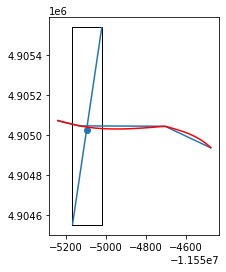

In [2]:
gagebasin = NLDI().getfeature_byid("nwissite", "USGS-06759500", basin=True).to_crs('epsg:3857')
gageloc = NLDI().getfeature_byid("nwissite", "USGS-06759500", basin=False).to_crs('epsg:3857')
strmseg_basin = NLDI().getfeature_byid("comid", "3561878", basin=True).to_crs('epsg:3857')
strmseg_loc = NLDI().getfeature_byid("comid", "3561878", basin=False).to_crs('epsg:3857')

# print(geomfeat.head(), geom2afeat.head())
xs = XSGen(point=gageloc, cl_geom=strmseg_loc, ny=100, width=1000)
xs_line = xs.get_xs()
ax = plt.subplot(111)
gageloc.plot(ax=ax)
strmseg_loc.plot(ax=ax)
xs_line.plot(ax=ax)
xs.get_strm_seg_spline().plot(ax=ax, colors='r')
xs_line.envelope.plot(ax=ax, facecolor="none", edgecolor='black')
plt.show()

In [42]:
gageloc

,geometry,source,sourceName,identifier,name,uri,comid,reachcode,measure,navigation
0,POINT (-11555095.804 4905022.842),nwissite,NWIS Sites,USGS-06759500,"SOUTH PLATTE RIVER AT FORT MORGAN, CO",https://waterdata.usgs.gov/monitoring-location...,3561878,10190012002368,94.8528800000,https://labs.waterdata.usgs.gov/api/nldi/linke...


In [45]:
strmseg_loc

,geometry,source,sourceName,identifier,name,uri,comid,navigation
0,"LINESTRING (-11555244.560 4905071.690, -115551...",comid,NHDPlus comid,3561878,,,3561878,https://labs.waterdata.usgs.gov/api/nldi/linke...


Use py3dep from Hydrodata to retrieve 3m DEM

(-11555267.48943957, -11554432.778117437, 4904448.7408951735, 4905637.87787599)

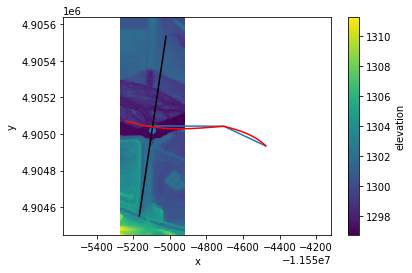

In [3]:
#Buffer bounding box of cross-section otherwise interpolation with elevation below returns nans near end points
t1 = (xs_line.total_bounds) + ((-100.,-100.,100., 100.))
dem = py3dep.get_map("DEM", tuple(t1), resolution=3, geo_crs="EPSG:3857", crs="epsg:3857")

ax = plt.subplot(111)
strmseg_loc.plot(ax=ax)
xs_line.plot(ax=ax, colors='black')
xs.get_strm_seg_spline().plot(ax=ax, colors='r')
xs_line.envelope.plot(ax=ax, facecolor="none", edgecolor='black')
dem.plot(ax=ax)
gageloc.plot(ax=ax)
ax.axis('equal')
# plt.tight_layout()

Get cross-section points and interpolate DEM to xs locations, Uses xarray interp method. Not sure how xarray does the interp - needs investigation.

<class 'xarray.core.dataarray.DataArray'>


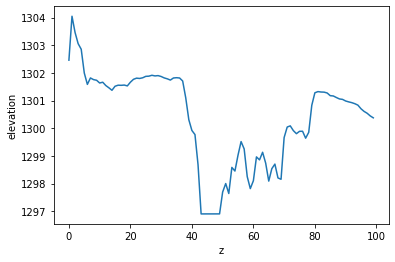

In [4]:
x,y = xs.get_xs_points()
dsx = xr.DataArray(x, dims='z')
dsy = xr.DataArray(y, dims='z')
dsi = dem.interp(x=('z',x), y=('z',y))
dsi.plot()
print(type(dsi))

Calculate distance (stationing) between points for flow calculation.  

In [5]:

x = dsi.coords['x'].values -dsi.coords['x'].values[0]
y = dsi.coords['y'].values -dsi.coords['y'].values[0]
dist = np.hypot(x,y)
elev = dsi.values
tlen = len(dist)
# print(tlen)
sta2 = np.zeros((tlen,2))
t = []
for index,(tx,ty) in enumerate(zip(dist,elev)):
    if not np.isnan(ty):
        a = np.array((tx,ty))
        sta2[index] = a
#         print(a)
    else:
        t.append(index)

Using pyGFT flow calculation Mannings steady uniform flow on arbitrary cross-section. I have not tested against some simple cross-sections to verify. Note units are metric

In [140]:
# d = np.delete(sta2, (t,(0,1)))
min_elev = np.min(sta2[:,1])
max_elev = np.max(sta2[:,0])
max_depth = 5.0
stage_values = np.linspace(min_elev, min_elev+max_depth, 20, dtype=float)
q_values = np.zeros(len(stage_values))
for index,ws in enumerate(stage_values):
    args = flowEst(wsElev=ws,slope=0.000049, n=.01, staElev=sta2, units='m')
    print(f'Q is {args[3]/0.0283}, velocity is {args[4]}top width {args[2]} and maxdepth {args[5]}')
    q_values[index] = args[3]

Q is 0.0, velocity is 0.0top width 8.298482612190128e-07 and maxdepth 0.0
Q is 163.64519630176358, velocity is 0.27979985187891276top width 65.46334118818402 and maxdepth 0.263157894736878
Q is 528.3703873180287, velocity is 0.4344237319027006top width 70.33615092956313 and maxdepth 0.526315789473756
Q is 1055.7390352816485, velocity is 0.5577191107859949top width 75.22757003302888 and maxdepth 0.789473684210634
Q is 1689.0742192158777, velocity is 0.6399307095537835top width 85.33091999537578 and maxdepth 1.0526315789472847
Q is 2539.9202558236307, velocity is 0.6944018724397952top width 104.58397532010184 and maxdepth 1.3157894736841627
Q is 3688.274600338391, velocity is 0.7931282695327309top width 108.89975580031245 and maxdepth 1.5789473684210407
Q is 4791.998621208983, velocity is 0.8282059832534869top width 126.98099765318221 and maxdepth 1.8421052631579187
Q is 6347.929101803038, velocity is 0.9068885756726521top width 134.0574362320935 and maxdepth 2.1052631578947967
Q is 8091

In [141]:
site='06759500'
meas = nwis.get_record(sites=site, service='measurements')
si = nwis.get_record(sites=site, service='site')

In [142]:
meas

,agency_cd,site_no,measurement_nu,measurement_dt,tz_cd,q_meas_used_fg,party_nm,site_visit_coll_agency_cd,gage_height_va,discharge_va,measured_rating_diff,gage_va_change,gage_va_time,control_type_cd,discharge_cd
0,USGS,06759500,1,2001-12-06 14:00:00,MST,Yes,DES/GJS,USGS,10.00,307.0,Fair,0.00,0.80,Clear,NONE
1,USGS,06759500,2,2002-01-03 12:35:00,MST,Yes,DES,USGS,9.82,246.0,Fair,0.00,0.60,IceShore,NONE
2,USGS,06759500,3,2002-02-04 15:25:00,MST,Yes,DES,USGS,10.07,323.0,Fair,0.00,0.60,Clear,NONE
3,USGS,06759500,4,2002-03-05 14:35:00,MST,Yes,DES,USGS,10.73,639.0,Fair,0.00,1.00,Clear,NONE
4,USGS,06759500,5,2002-04-24 09:50:00,MDT,Yes,DES,USGS,9.17,37.3,Fair,0.00,0.40,Clear,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,USGS,06759500,218,2020-06-19 13:01:00,MDT,Yes,RJB,USGS,8.44,124.0,Fair,0.00,0.97,Clear,NONE
218,USGS,06759500,219,2020-08-05 14:02:30,MDT,Yes,RJB,USGS,8.90,289.0,Fair,-0.24,0.82,Clear,BYPS
219,USGS,06759500,220,2020-09-16 13:08:30,MDT,Yes,RJB,USGS,9.38,504.0,Fair,0.00,1.08,Clear,NONE
220,USGS,06759500,221,2020-10-21 12:08:30,MDT,Yes,RJB,USGS,8.69,216.0,Fair,-0.01,0.72,Clear,NONE


In [143]:
meas1 = meas.loc[(meas['measured_rating_diff'].isin(['Good','Fair']))]
meas1.head()
meas1.reset_index(inplace = True)

C:\Users\rmcd\Miniconda3\envs\nldi_xstool\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\rmcd\Miniconda3\envs\nldi_xstool\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


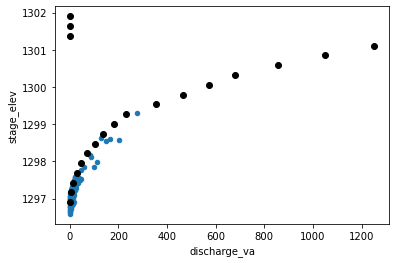

In [144]:
meas1.loc[:,'stage_elev'] = meas1.loc[:,'gage_height_va'].values
meas1.loc[:,'stage_elev'] += si.loc[:,'alt_va'].values
meas1.loc[:,'stage_elev'] *= 0.3048
meas1.loc[:,'discharge_va'] *= 0.02831
# meas = pd.read_csv('usgs06759500.csv', header=None, names=['stage','discharge'])
ax = plt.subplot(111)
meas1.plot.scatter(x='discharge_va', y='stage_elev', ax = ax)
plt.scatter(q_values, stage_values, color='black')

In [170]:
min_elev = np.min(sta2[:,1])
max_elev = np.max(sta2[:,0])
max_depth = 5.0
stage_values = meas1.stage_elev.values
sv = stage_values[stage_values > min_elev]
q_values = np.zeros(len(sv))
for index,ws in enumerate(sv):
    args = flowEst(wsElev=ws,slope=0.000049, n=.01, staElev=sta2, units='m')
    print(f'{index}, ws is {ws}, Q is {args[3]}, MQ is {meas1.discharge_va[index]}')
    q_values[index] = args[3]

0, ws is 1297.2562320000002, Q is 7.593540849106916, MQ is 8.69117
1, ws is 1297.201368, Q is 5.708858356590622, MQ is 6.9642599999999995
2, ws is 1297.277568, Q is 8.385681805244868, MQ is 9.144129999999999
3, ws is 1297.478736, Q is 17.39696506594414, MQ is 18.09009
4, ws is 1297.0032480000002, Q is 0.9070501267809578, MQ is 1.0559629999999998
5, ws is 1297.1190720000002, Q is 3.3118358764823688, MQ is 3.00086
6, ws is 1297.4634960000003, Q is 16.619807577521453, MQ is 17.63713
7, ws is 1297.0764000000001, Q is 2.2855716204621084, MQ is 2.335575
8, ws is 1297.0703040000003, Q is 2.151771560728882, MQ is 2.287448
9, ws is 1297.03068, Q is 1.3642568467185316, MQ is 1.5570499999999998
10, ws is 1297.2166080000002, Q is 6.2100484547184225, MQ is 5.20904
11, ws is 1297.1952720000002, Q is 5.513273637119458, MQ is 5.20904
12, ws is 1297.189176, Q is 5.3205066752261185, MQ is 5.152419999999999
13, ws is 1297.2745200000002, Q is 8.270524056229304, MQ is 6.935949999999999
14, ws is 1297.48788

In [171]:
meas1.discharge_va

0       8.691170
1       6.964260
2       9.144130
3      18.090090
4       1.055963
         ...    
180     3.510440
181     8.181590
182    14.268240
183     6.114960
184     5.945100
Name: discharge_va, Length: 185, dtype: float64

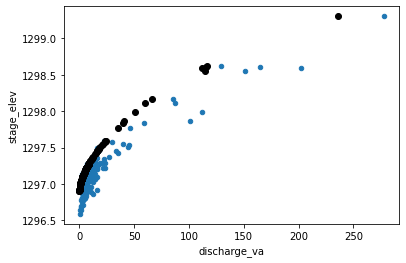

In [173]:
ax = plt.subplot(111)
meas1.plot.scatter(x='discharge_va', y='stage_elev', ax = ax)
plt.scatter(q_values, sv, color='black')

In [174]:
gagebasin = NLDI().getfeature_byid("nwissite", "USGS-0672100", basin=True).to_crs('epsg:3857')
gageloc = NLDI().getfeature_byid("nwissite", "USGS-0672100", basin=False).to_crs('epsg:3857')
gageloc
# strmseg_basin = NLDI().getfeature_byid("comid", "3561878", basin=True).to_crs('epsg:3857')
# strmseg_loc = NLDI().getfeature_byid("comid", "3561878", basin=False).to_crs('epsg:3857')

ConnectionError: Connection failed after 3 retries.

In [61]:
slope = pd.read_csv(r'elevslope.csv')

In [67]:
slope[slope.COMID==3561878]

,COMID,FDATE,MAXELEVRAW,MINELEVRAW,MAXELEVSMO,MINELEVSMO,SLOPE,ELEVFIXED,HWTYPE,STATUSFLAG,SLOPELENKM
24181,3561878,6/30/2009,-9998.0,129917.0,129920.0,129917.0,0.000049,0,NaN,A,0.606


In [56]:
#3561878,6.49,0.09,1328.19,1299.17,1344.73,0,0.606
slope = (1344.73-1299.17)/606.0
print(slope)

0.07518151815181509
